In [210]:
%load_ext autoreload
%autoreload 2
import cv2
import numpy as np
import os
from IPython.display import HTML, display
from pathlib import Path
from matplotlib import pyplot as plt
from src.vo import *
from src.pinhole import Pinhole
from src.feature import Feature3D, Feature2D, DummyKp
from PIL import Image

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
root = Path('sample')
drive = '00'

seq_path = root / 'data_odometry_gray' / 'dataset' / drive / 'image_0'
frames = sorted(os.listdir(seq_path))
vo = VO()

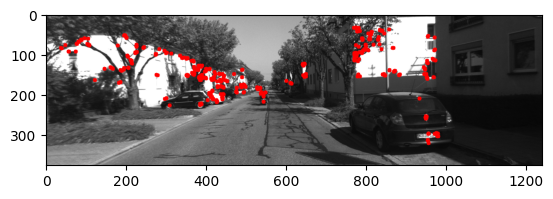

In [7]:
vo.append(cv2.imread(str(seq_path / frames[0]), cv2.IMREAD_UNCHANGED))
vo.append(cv2.imread(str(seq_path / frames[1]), cv2.IMREAD_UNCHANGED))

plt.imshow(show_features(vo.frames[-1], vo.keypoints[-1]))
plt.show()

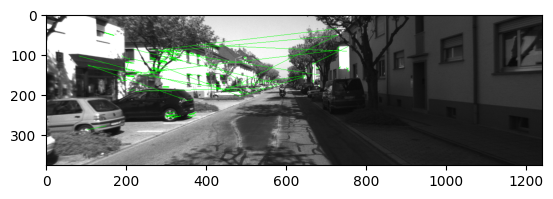

In [11]:
plt.imshow(show_deltas(vo))
plt.show()

In [12]:
vo.reset()
title = "displacement vectors"
cv2.namedWindow(title)

for frame in frames:
    I = cv2.imread(str(seq_path / frame), cv2.IMREAD_UNCHANGED)
    vo.append(I)
    
    if len(vo.frames) >= 2:
        cv2.imshow(title, show_deltas(vo, max_distance=20))
        cv2.waitKey()
        
cv2.destroyWindow(title)

With keypoints detected and matched, we can now focus on deriving matrices that describe the projection characteristics of the camera, as well as solving for a transformation matrix which places the keypoints from $ t $ to $ t_1 $.

For the current frame $F_t$ each keypoint in that frame $k_{i,t}$ represents a specific 3D world space point $p_{i,t}$. If we can match a subset of these points in the next frame $F_{t+1}$, such that $p_{i,t+1}$ represents the same physical point in space as its predecesor, then it follows that some transformation matrix $T_{t,t+1}$ could be applied to $p_{i,t}$ such that it yeilds it's successor. More concretely.

$ p_{i,t+1} = T_{t,t+1} * p_{i,t} $

However, the keypoints themselves $k_i,t$ are projected onto the frame, and thus are two dimensional meaning the projection matrix $P$ must be rank 2. so we can't recover the 3D points directly via an application of the inverse. The transformation from world space points to keypoints is the following.

$ k_{i,t+1} = P * T_{t,t+1} * p_{i,t} $

Our goal is to estimate $T$. There are some known variables such as, $k_{i,t}$, and $P$. However, we're left with as many unknown variables $T_{t,t+1}$, and $p_{i,t}$.

We could write an objective function for $T_{t,t+1}$ to assess the quality of a given solution as:

$ O(T_{t,t+1}) = \frac{1}{n} * \sum_{i=0}^n ||k_{i,t+1} - (P * T_{t,t+1} * p_{i,t})||$



# Retrieving Geometry Through Apparent Motion
In the code below we attempt to retrieve the 3D position of points projected on a pin-hole camera's sensor. Both the camera and ground truth points are position in the same reference frame. We assume the knowledge of the following:

* Camera's pose
* Camera's intrinsics

## Virtual Camera and Projection

The projection described below explains how virtual images of virtual objects are constructed for this experiment.

Our pin-hole camera model has a single parameter for the focal length $f$, a transformation (pose) in the world coordinate space $T$. A projection matrix $P$ is constructed which applies a perspective tranform to any given point $p \in S^3$. This projection is defined as:

$P = \begin{bmatrix}1 & 0 & 0 & 0\\0 & 1 & 0 & 0\\0 & 0 & 1 & 0\\0 & 0 & -1/f & 0\end{bmatrix}$

The projection is performed by first augmenting a point $p$ then performing the multiplication

$p' = T^{-1} P \begin{bmatrix}p_x\\p_y\\p_z\\1\end{bmatrix}$

Which is then used to compute the coordinate $s$ on the sensor plane

$s = \begin{bmatrix}p'_x\\p'_y\end{bmatrix} / p'_w$

Clamping of the coordinate $s$ is applied so that points projected outside of the plane are rejected.

The location of the aperature in world space coordinates is defined as:

$a = T \begin{bmatrix}0\\0\\0\\1\end{bmatrix}$

## Point Reconstruction

For some sequence of images $I$ we will produce a sequence of keypoints $K$ using a feature detector. $I^f$ refers to the image intensities of the $f^{th}$ frame. Similarly, $K^f$ refers to the keypoints found in the $f^{th}$ frame as a function of $I^f$.

Each keypoint $k^f_{i}$, the $i^{th}$ keypoint in the $f^{th}$ frame, has two main attributes a descriptor $d^f_{i}$ and a sensor plane coordinate $s_{fi}$. The descriptor $d_{fi}$ is an identifier used to associate each keypoint with its counter parts in subsequent frames.

For each frame and it's successor we wish to find $K^{f-1} \in K^f \rightarrow M^{f-1}_f$ which implies a set of matches between frame $f-1$ and $f$. Each keypoint has a location on the sensor's image plane, which in turn has a physical location in world space. We can find the position of a point on the sensor plane in world space for any keypoint $s^f_{i}$ as:

$p^f_{i} = T^f \begin{bmatrix}s^f_{i_{x}}\\s^f_{i_{y}}\\-f\\1\end{bmatrix}$

Where $T^f$ is the pose transform of the camera for the $f^{th}$ frame. Using this equation we can retrieve these positions in world coordinates for a matching pair $p^f_{i}$ and $p^{f-1}_{i}$. With this coordinate pair in hand, we can also compute the aperature locations $a^f$ and $a^{f-1}$ for the corresponding frames. With these four positions, we have the appropriate geometry to recover $p$ as illustrated in the diagram below.

<center>
<img src="multi-view-geometry.svg"/>
</center>

Next using these positions from $f$ and $f-1$ we can conceive of two rays, where the first vector in the pair is the origin and the second is the direction. 

_Note: the $w$ components of all $S^4$ vectors are discarded_

$r^f = ( p^f_{i}, a^f - p^f_{i} )$

$r^{f-1} = ( p^{f-1}_{i}, a^{f-1} - p^{f-1}_{i} )$

We construct a plane with normal $n$ which $r^{f-1}$ lies in (i.e. $n \cdot r^{f-1} = 0$). An additional constraint for the plane is that the camera's up vector $u^{f-1}$ (vertical axis on the sensor plane) must also lie in this plane and $p^{f-1}_{i}$ must be at the plane's origin. The up and normal vectors are computed as:

$u^{f-1} = T^{f-1} \begin{bmatrix}0\\1\\0\\0\end{bmatrix}$

$n = u^{f-1} \bigtimes (a^{f-1} - p^{f-1}_{i})$ 

Next we solve for an intersection parameter $t$ between ray $r^f$ and the plane defined above:

$ t = \frac{(p^{f-1}_{i} - r^f_{o}) \cdot n}{r^f_{d} \cdot n} $

Which in turn allows us to retrieve an approximation of the original point $p$ as

$\tilde{p} = r^f_{o} + r^f_{d} * t$

In [173]:
frames = 15
I = np.zeros((frames, 128, 128, 3), dtype=np.uint8) * 255

def cube_colors(v):
    return (v * 32 + (128 + 32)).astype(np.uint8)

verts, colors = cube(d=2, position=vec(0, 0, 10), color_for_coord=cube_colors)
verts, colors = verts[1:2], colors[1:2]

dp = vec(0, 0, 0.5)
cam = Pinhole(I[0])
vo = VO(cam)

assert(vo.size() == 0)

noise = (np.random.default_rng().random((32,3,3,3))) # * 32).astype(np.uint8)

for f in range(frames):
    cp = dp * (f+4) # camera pos
    T = translate(cp)
    cam.set_frame(I[f])
    cam.set_transform(T)

    # render verts to camera frame
    for i, (v, c) in enumerate(zip(verts, colors)):
        coord = cam.project(v, c)
        if coord is not None:
            # draw a little patch with noise around the point
            I[f,coord[1]-1:coord[1]+2,coord[0]-1:coord[0]+2] = (c * noise[i]).astype(np.uint8)       

    # hand the frame and transform to VO instance, produces estimates
    est_verts = vo.append(I[f], T)

    # render location of reconstructed verts into frame
    if est_verts is not None:
        for v in est_verts:
            if v is None:
                continue
            coord = cam.project(v, None)
            cv2.circle(I[f],(coord[0],coord[1]),5,(255, 128, 0),1)

    # show_features(I[f], vo.keypoints[f])
    show_deltas(vo, index=f)
    
    cv2.putText(I[f], f"f:{f} kps:{len(vo.keypoints[f])}", (10, 10), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 255, 255), 1)
    
imgs = [Image.fromarray(
    img).resize((256, 256), resample=Image.NEAREST) for img in I]
imgs[0].save("motion.gif", save_all=True, append_images=imgs[1:], duration=10, loop=0)

display(HTML('<img src="motion.gif" ' +
             'alt="Schema of adaptive filter" ' +
             'height="100">'))

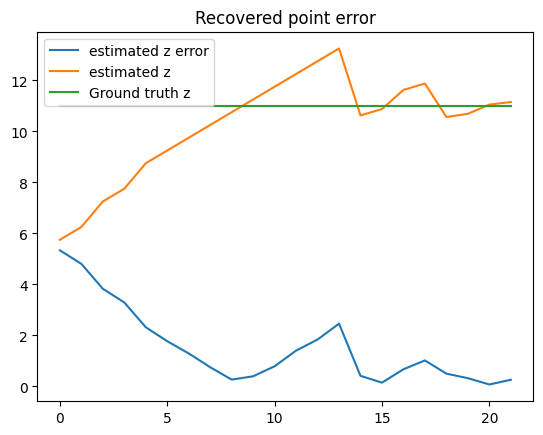

In [174]:
error = []
z = []
for fpes in vo.point_estimates:
    for fpe in fpes:
        if fpe is None:
            continue

        error.append(np.linalg.norm(fpe - verts[0]))
        z.append(fpe[2])

plt.title("Recovered point error")
plt.plot(error, label="estimated z error")
plt.plot(z, label="estimated z")
plt.plot([verts[0][2]] * len(z), label="Ground truth z")
plt.legend()
plt.show()

## Conclusion

The plotted error shows that the further the projected point is from the camera, the less accurate its estimated depth is. This is easily explained by the discrete nature of the pixels in the sensor plane. The apparent motion of the projected image is inversely proportional to the distance of the subject to the camera. This means that the displacement of features in image space is smaller at greater distances. Some times this displacement might be too small and will result in the feature appearing to remain stationary.

As the object comes closer, these displacements become larger in magnitude which makes the signal clearer and the retrieved distance is more accurate. There are two ways I could see this being addressed:

1. Increase the resolution of the sensor
2. Apply a Kalman filter to the point in image space. (Could also be applied to 3-space point)

Out of the two options, I think the Kalman filter is most scalable. Plus with a slightly less naive structure for tracking keypoints, it could track the same point over longer durations treating each keypoint detection as an "observation" rather than an authority of the point's true location. This could allow for lapses of detection, etc.

# Tracking Redesign

A thought that occurred to me while working on the code above. When tracking the same point over a trajectory, there are often one or more consecutive frames where no keypoints are detected. This means that the assumption that a continguous sequence of keypoints for a given real-world feature can not be expected to exist. For this reason, a mechanism for persisting features which may outlive one or more sets of keypoints seems like a reasonable thing to try.

## Feature Tracking Design

1. Dynamics model
2. Spawn criteria
3. Despawn criteria

### Spawn Criteria Options

1. Feature spawns immediately, but goes through a maturation process. Maturation would require some number of consecutive detections before considered "mature".
2. Feature spawns immediately, and builds maturity gradually through detections. Maturity can decay with no detection.
3. Feature spawns after two consecutive detections, then follows option 1, or 2.

### Dynamics Model

This will almost certainly be a Kalman filter. The structure of the state vector could take one of two paths, which will inform the subsequent choices.

**2D state in screen space**

1. position x
2. position y
3. velocity x
4. velocity y
5. acceleration x
6. acceleration y

**3D state in world space**

1. position x
2. position y
3. position z

#### F (stm)

Models how the estimated state should change over time

🙂 In the 3D case, this would simply be the identity since we're assuming the point is static.

😐 In the 2D case:
\begin{bmatrix}1&0&dt&0&0&0\\0&1&0&dt&0&0\\0&0&1&0&dt&0\\0&0&0&1&0&dt\\0&0&0&0&1&0\\0&0&0&0&0&1\\\end{bmatrix}

#### B (control input model)

Should model how we expect observations to change based on controls we apply to the camera's transform.

🙂 In the 3D case, this could simply be changes to the camera's world transform, $\Delta{T^f}$

☹️ In the 2D case, it's not clear how this would work since we don't know how the projection will effect an arbitray 2D point without depth information

#### H (observation matrix)

Maps state space into observation space.

🙂 In the 3D case, we can just use the projection matrix $P$. 😐 Actually, this is not true. The point isn't projected into image space directly. The step of dividing the resulting projection by its $w$ component is a necessary second step and cannot be handled by a transform alone. A reformulation of the traditional 4x4 matrix may work, however it will require updates for each observation.

$w = -p_z / f$

$H = \begin{bmatrix}1/w&0&0&0\\0&1/w&0&0\\\end{bmatrix}$

🙂 In the 2D case, the observation and state exist in the same space, so we could literally use the identity.


Based on the tallying above the 3D representation wins handily. This is appropriate anyway since what we're trying to do is estimate the 3D position anyway, so we may as well do it in our tracking.

### Feature matching

Project covariance ellipse into the camera frame. Use this as a basis for where the keypoints corresponding to any given feature may be found.

In [205]:
frames = 18
I = np.zeros((frames, 128, 128, 3), dtype=np.uint8) * 255
keypoints = []
poses = []
recovered_points = []
dp = vec(0, 0, 0.5)
cam = Pinhole(I[0])
feat = None

p = vec(1, 1, 1) + vec(0, 0, 10)

for f in range(frames):
    cp = dp * (f+4) # camera pos
    T = translate(cp)
    poses.append(T)
    cam.set_frame(I[f])
    cam.set_transform(T)

    z = cam.project(p, np.array([255] * 3, dtype=np.uint8))
    if z is not None:
        keypoints.append([DummyKp(z)])
    else:
        keypoints.append([None])

    if f > 1 and feat is None and (keypoints[-2][0].pt != keypoints[-1][0].pt).any():
        print(keypoints[-2][0].pt, keypoints[-1][0].pt)
        feat = Feature3D(cam, keypoints[-2:], poses[-2:])
    
    if feat is not None:
        p_prime = feat.update(keypoints[-1], poses[-1])
        recovered_points.append(p_prime)
        coord = cam.project(feat._kf.x[:3], np.array([255, 0, 0], dtype=np.uint8))
        if coord is not None:
            centroid, a, b = feat.covariance_ellipse()
            cv2.ellipse(I[f], (int(centroid[0]), int(centroid[1])), (int(a), int(b)), 0, 0, 360, (0, 255, 0), 1)
            
        if feat.expiring():
            feat = None
            print("Feature expired")


imgs = [Image.fromarray(
    img).resize((256, 256), resample=Image.NEAREST) for img in I]
imgs[0].save("feature.gif", save_all=True, append_images=imgs[1:], duration=10, loop=0)
display(HTML('<img src="feature.gif" ' +
             'alt="Kalman Filter applied to estimated point" ' +
             'height="100">'))

[58 58] [57 57]


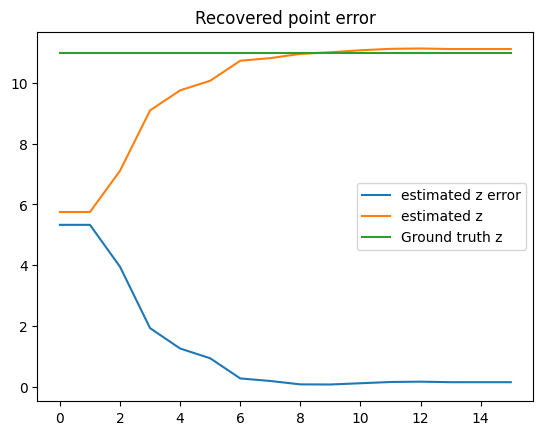

In [206]:
error = []
z = []
for fpe in recovered_points:
    if fpe is None:
        continue

    error.append(np.linalg.norm(fpe - p))
    z.append(fpe[2])

plt.title("Recovered point error")
plt.plot(error, label="estimated z error")
plt.plot(z, label="estimated z")
plt.plot([p[2]] * len(z), label="Ground truth z")
plt.legend()
plt.show()

This converged much more consistently, and didn't oscillate. The KF for the point in 3d space has essentially no dynamics so I suspect this boiled down to being little more than an EMA. Filtering keypoints in 2d space is probably more promising since you could acquire sub-pixel resolution of motion. 

In [344]:
from src.utils import point_from_motion

frames = 25
I = np.zeros((frames, 128, 128, 3), dtype=np.uint8) * 255
keypoints = []
poses = []
recovered_points = []
predicted_feature_loc = []
dp = vec(0, 0, 0.5)
# dp = vec(0.5, 0, 0)
cam = Pinhole(I[0])
feat = None

p = vec(1, 1, 1) + vec(0, 0, 10)

for f in range(frames):
    cp = dp * (f) # camera pos
    # cp = vec(np.sin(np.pi * f / 20) * 8, 0, 0)
    T = translate(cp)
    poses.append(T)
    cam.set_frame(I[f])
    cam.set_transform(T)

    z = cam.project(p, np.array([255] * 3, dtype=np.uint8))
    if z is not None: # and np.random.random() < 0.75:
        keypoints.append(DummyKp(z))
    else:
        keypoints.append(None)

    if feat is None and f > 1 and keypoints[-2] != None and keypoints[-1] != None: #(keypoints[-2].pt != keypoints[-1].pt).any():
        print(keypoints[-2].pt, keypoints[-1].pt)
        feat = Feature2D(cam, keypoints[-2:], poses[-2:])
        print("new feature")
    
    if feat is not None:
        p_prime = feat.update(keypoints[-1], poses[-1])
        predicted_feature_loc += [p_prime]
        recovered_points.append(point_from_motion(cam, p_prime[:2] - p_prime[2:4], p_prime[:2], poses[-2], poses[-1]))
        
        centroid, a, b = feat.covariance_ellipse()
        I[f,int(centroid[1]), int(centroid[0])] = np.array([255, 0, 0])
        cv2.ellipse(I[f], (int(centroid[0]), int(centroid[1])), (int(a), int(b)), 0, 0, 360, (0, 255, 0), 1)
        
        if feat.expiring():
            # feat = None
            print("Feature expired")


imgs = [Image.fromarray(
    img).resize((256, 256), resample=Image.NEAREST) for img in I]
imgs[0].save("feature.gif", save_all=True, append_images=imgs[1:], duration=10, loop=0)
display(HTML('<img src="feature.gif" ' +
             'alt="Kalman Filter applied to estimated point" ' +
             'height="100">'))

[59 59] [59 59]
new feature
Feature expired
Feature expired


/Users/kirkroerig/repos/visual-odometry/src/pinhole.py:29: RuntimeWarning: divide by zero encountered in scalar divide
  return np.array([
/Users/kirkroerig/repos/visual-odometry/src/pinhole.py:30: RuntimeWarning: divide by zero encountered in scalar divide
  [-1/(self._f * z),                 0,   0],


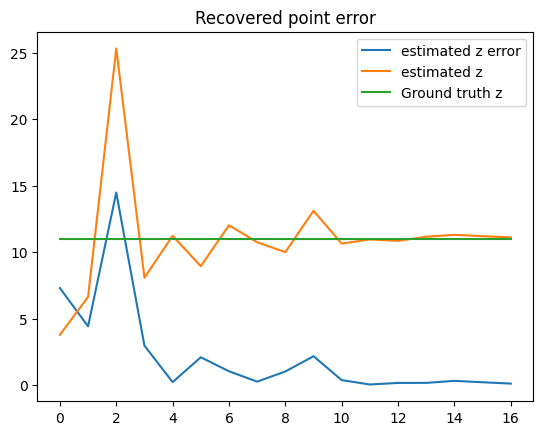

In [343]:
error = []
z = []
for fpe in recovered_points:
    if fpe is None:
        continue

    error.append(np.linalg.norm(fpe - p))
    z.append(fpe[2])

plt.title("Recovered point error")
plt.plot(error, label="estimated z error")
plt.plot(z, label="estimated z")
plt.plot([p[2]] * len(z), label="Ground truth z")
plt.legend()
plt.show()

The 2D filtering has an initially low error which then increases substantially before converging again. It the source of this behavior can be found, this seems like an optimal signal to use. Pairing this with an EMA (or possibly Kalman) filter would be a great pairing.

In [329]:
np.random.random()

0.6015208791143751